# From unstructured text to visualization
## Political science course

In this notebook, we will explore different ways of visualizing unstructured text data. This second notebook will introduce networks, topic modeling, temporal analysis.

## Networks
First, we will look at networks. Networks are typically calculated for entities that often occur together.

In [ ]:
import pandas as pd
edge_count_url = "https://raw.githubusercontent.com/daalft/polviz/main/data/bills_edges.csv"
edge_counts = pd.read_csv(edge_count_url, sep='\t')

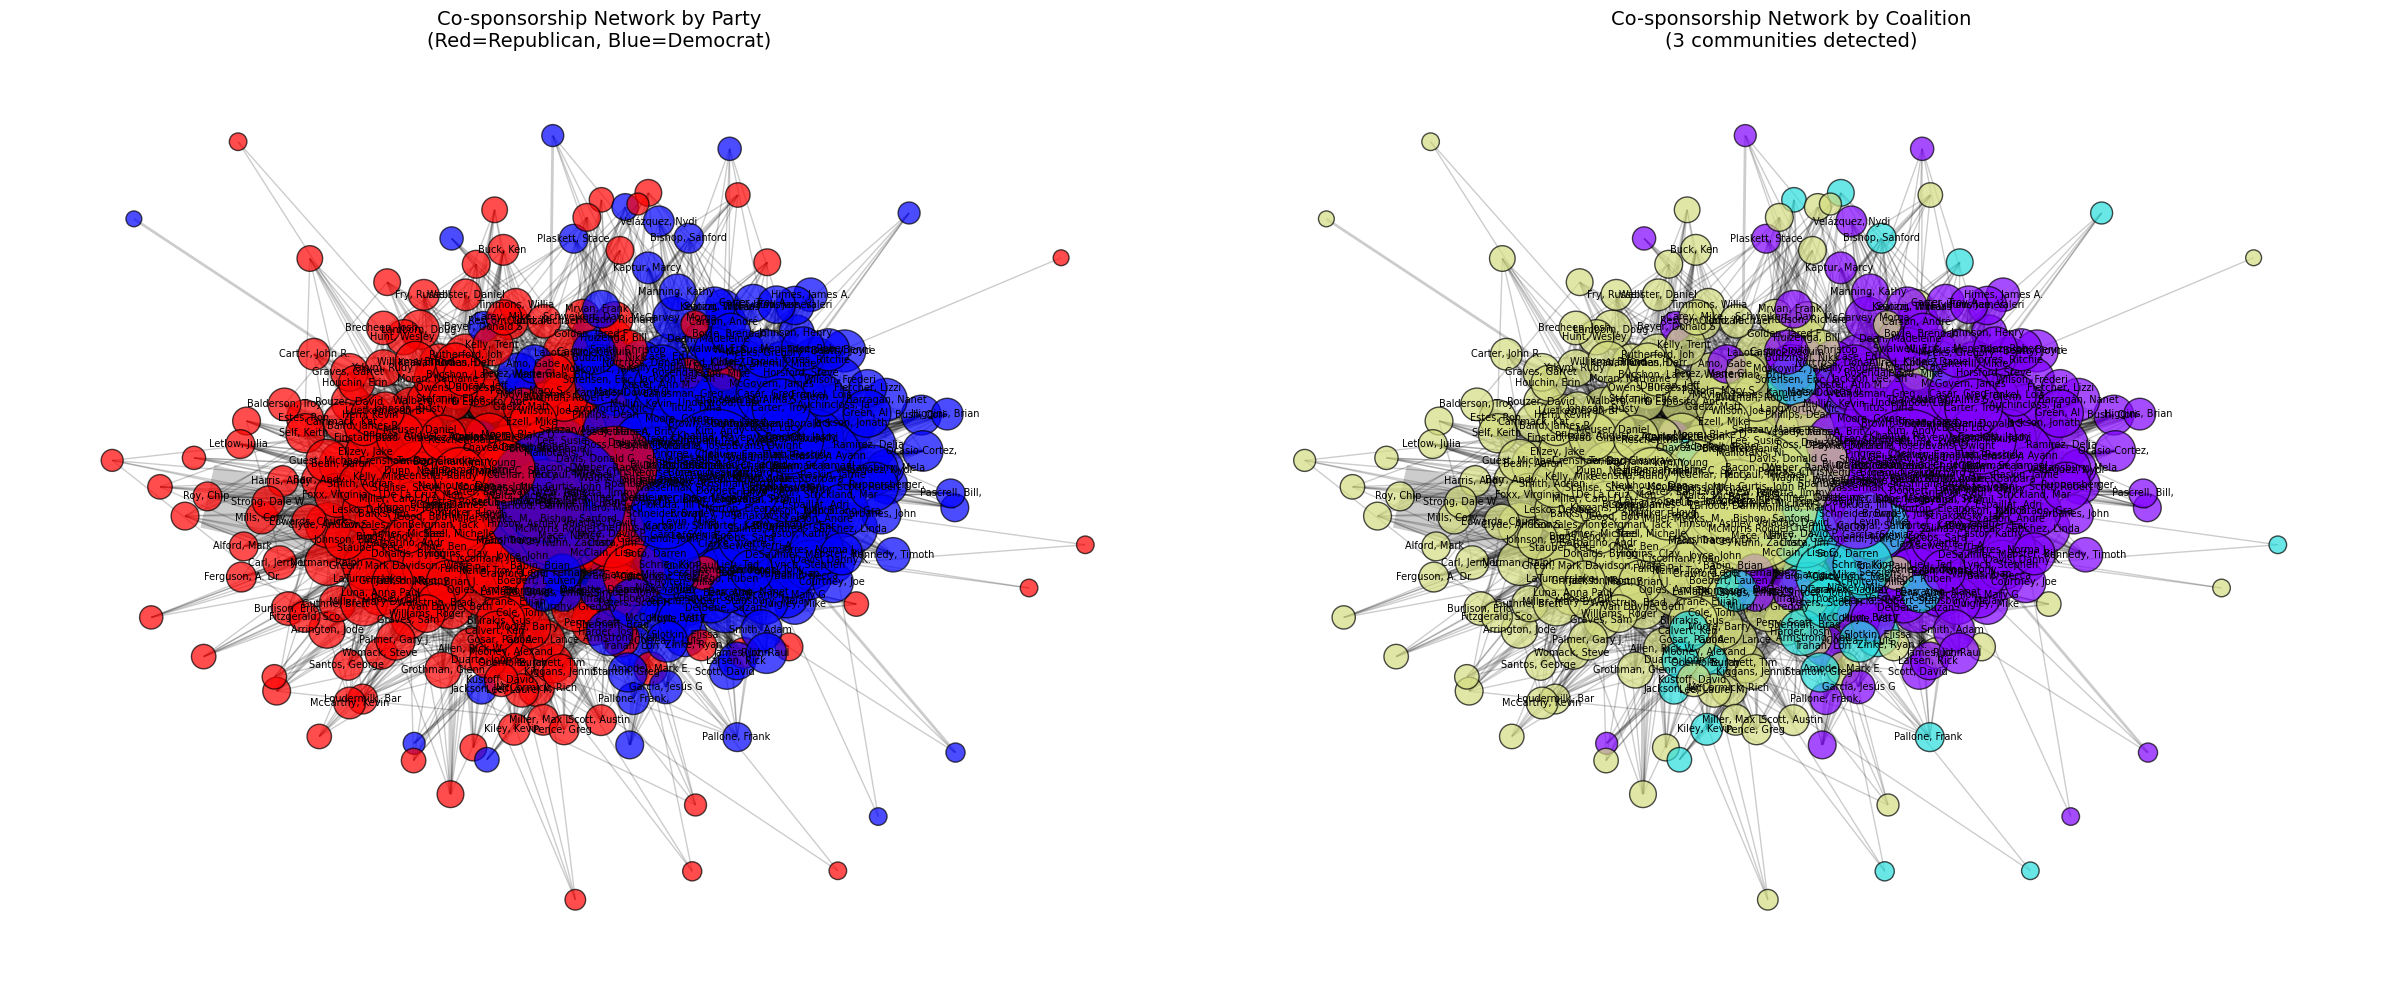


COALITION ANALYSIS

Coalition 2:
  Size: 230 members
  Party breakdown: 218 R, 12 D
  Internal connections: 3132
  Key members:
    - Rep. Moulton, Seth
    - Rep. Smucker, Lloyd
    - Rep. Comer, James

Coalition 0:
  Size: 194 members
  Party breakdown: 1 R, 193 D
  Internal connections: 4307
  Key members:
    - Rep. Fitzpatrick, Brian K.
    - Rep. Davids, Sharice
    - Rep. Pocan, Mark

Coalition 1:
  Size: 45 members
  Party breakdown: 17 R, 28 D
  Internal connections: 163
  Key members:
    - Rep. Wagner, Ann
    - Rep. Carbajal, Salud O.
    - Rep. McClintock, Tom

BIPARTISAN BRIDGE ANALYSIS

Top 10 Most Bipartisan Members:
1. Rep. Fitzpatrick, Brian K. (Republican)
   Bipartisan score: 79.32% | Total connections: 266
2. Rep. Lee, Susie (Democrat)
   Bipartisan score: 74.19% | Total connections: 31
3. Rep. Garcia, Mike (Republican)
   Bipartisan score: 68.25% | Total connections: 63
4. Rep. McClintock, Tom (Republican)
   Bipartisan score: 67.21% | Total connections: 61
5. Re

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Create network graph
G = nx.from_pandas_edgelist(
    edge_counts,
    source='sponsor',
    target='cosponsor',
    edge_attr='count',
    create_using=nx.Graph()
)

# Helper function
def get_party(name):
    if '[R-' in name:
        return 'Republican'
    elif '[D-' in name:
        return 'Democrat'
    else:
        return 'Other'

# Detect communities using NetworkX's built-in Louvain
communities_generator = nx.community.louvain_communities(G, seed=42)
# Convert to dictionary format {node: community_id}
communities = {}
for comm_id, community_set in enumerate(communities_generator):
    for node in community_set:
        communities[node] = comm_id

# Add attributes
for node in G.nodes():
    G.nodes[node]['party'] = get_party(node)
    G.nodes[node]['community'] = communities[node]

# === VISUALIZATION 1: Party-based network ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Left plot: Colored by party
party_colors = {'Republican': 'red', 'Democrat': 'blue', 'Other': 'gray'}
node_colors_party = [party_colors[get_party(node)] for node in G.nodes()]
node_sizes = [100 + G.degree(node) * 30 for node in G.nodes()]

pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

# Draw edges
edges = G.edges()
weights = [G[u][v]['count'] for u, v in edges]
nx.draw_networkx_edges(G, pos, alpha=0.2, width=weights, ax=ax1)

# Draw nodes
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors_party,
    node_size=node_sizes,
    alpha=0.7,
    edgecolors='black',
    linewidths=1,
    ax=ax1
)

# Label high-degree nodes
high_degree = [n for n in G.nodes() if G.degree(n) > 10]
labels = {n: n.split('[')[0].replace('Rep. ', '').replace('Del. ', '')[:15] for n in high_degree}
nx.draw_networkx_labels(G, pos, labels, font_size=7, ax=ax1)

ax1.set_title('Co-sponsorship Network by Party\n(Red=Republican, Blue=Democrat)', fontsize=14)
ax1.axis('off')

# Right plot: Colored by coalition
import matplotlib.cm as cm
n_communities = len(set(communities.values()))
colors = cm.rainbow([i/n_communities for i in range(n_communities)])
community_color_map = {comm: colors[i] for i, comm in enumerate(set(communities.values()))}
node_colors_comm = [community_color_map[communities[node]] for node in G.nodes()]

nx.draw_networkx_edges(G, pos, alpha=0.2, width=weights, ax=ax2)
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors_comm,
    node_size=node_sizes,
    alpha=0.7,
    edgecolors='black',
    linewidths=1,
    ax=ax2
)
nx.draw_networkx_labels(G, pos, labels, font_size=7, ax=ax2)

ax2.set_title(f'Co-sponsorship Network by Coalition\n({n_communities} communities detected)', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()

# === COALITION ANALYSIS ===
print("\n" + "="*60)
print("COALITION ANALYSIS")
print("="*60)

community_stats = {}
for comm_id in set(communities.values()):
    members = [node for node, comm in communities.items() if comm == comm_id]
    parties = Counter([get_party(member) for member in members])

    # Calculate internal connections
    subgraph = G.subgraph(members)
    internal_edges = subgraph.number_of_edges()

    community_stats[comm_id] = {
        'size': len(members),
        'republicans': parties.get('Republican', 0),
        'democrats': parties.get('Democrat', 0),
        'internal_connections': internal_edges,
        'members': members
    }

# Sort by size
sorted_communities = sorted(community_stats.items(), key=lambda x: x[1]['size'], reverse=True)

for comm_id, stats in sorted_communities[:10]:  # Top 10
    print(f"\nCoalition {comm_id}:")
    print(f"  Size: {stats['size']} members")
    print(f"  Party breakdown: {stats['republicans']} R, {stats['democrats']} D")
    print(f"  Internal connections: {stats['internal_connections']}")

    # Find leaders
    members = stats['members']
    subgraph = G.subgraph(members)
    centrality = nx.degree_centrality(subgraph)
    top_3 = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:3]

    print(f"  Key members:")
    for member, score in top_3:
        print(f"    - {member.split('[')[0].strip()}")

# === BIPARTISAN ANALYSIS ===
print("\n" + "="*60)
print("BIPARTISAN BRIDGE ANALYSIS")
print("="*60)

bipartisan_scores = {}
for node in G.nodes():
    neighbors = list(G.neighbors(node))
    if len(neighbors) >= 3:  # Minimum connections
        node_party = get_party(node)
        opposite_party = sum(1 for n in neighbors if get_party(n) != node_party)
        bipartisan_scores[node] = opposite_party / len(neighbors)

# Top bipartisan members
top_bipartisan = sorted(bipartisan_scores.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Most Bipartisan Members:")
for i, (member, score) in enumerate(top_bipartisan, 1):
    party = get_party(member)
    connections = G.degree(member)
    print(f"{i}. {member.split('[')[0].strip()} ({party})")
    print(f"   Bipartisan score: {score:.2%} | Total connections: {connections}")

## Topic Modeling
Next, we will look at topic modeling. Topic modeling does not typically require pre-processing such as tokenization and will often perform pre-processing steps itself, often a tf-idf to remove redundant information.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

class BillsTopicModeling:
    """Topic modeling pipeline for legislative bills"""

    def __init__(self, bills_data, n_topics=5):
        """
        Initialize the topic modeling pipeline

        Parameters:
        -----------
        bills_data : list of lists
            Each inner list contains text snippets for one bill
        n_topics : int
            Number of topics to extract
        """
        self.bills_data = bills_data
        self.n_topics = n_topics
        self.documents = self._prepare_documents()
        self.vectorizer = None
        self.doc_term_matrix = None
        self.model = None
        self.doc_topics = None

    def _prepare_documents(self):
        """Combine text snippets into documents"""
        documents = []
        for bill in self.bills_data:
            # Join all text snippets for each bill
            doc = ' '.join([str(text) for text in bill if text])
            documents.append(doc)
        return documents

    def preprocess_and_vectorize(self, method='tfidf', max_features=1000):
        """
        Vectorize documents

        Parameters:
        -----------
        method : str
            'tfidf' or 'count' for vectorization method
        max_features : int
            Maximum number of features to extract
        """
        if method == 'tfidf':
            self.vectorizer = TfidfVectorizer(
                max_features=max_features,
                min_df=1,
                max_df=0.95,
                stop_words='english',
                ngram_range=(1, 2)
            )
        else:
            self.vectorizer = CountVectorizer(
                max_features=max_features,
                min_df=1,
                max_df=0.95,
                stop_words='english',
                ngram_range=(1, 2)
            )

        self.doc_term_matrix = self.vectorizer.fit_transform(self.documents)
        return self.doc_term_matrix

    def fit_lda(self, random_state=42):
        """Fit LDA topic model"""
        self.model = LatentDirichletAllocation(
            n_components=self.n_topics,
            random_state=random_state,
            max_iter=50,
            learning_method='online',
            n_jobs=-1
        )
        self.doc_topics = self.model.fit_transform(self.doc_term_matrix)
        return self.model

    def fit_nmf(self, random_state=42):
        """Fit NMF topic model (alternative to LDA)"""
        self.model = NMF(
            n_components=self.n_topics,
            random_state=random_state,
            max_iter=500,
            init='nndsvda'
        )
        self.doc_topics = self.model.fit_transform(self.doc_term_matrix)
        return self.model

    def get_top_words(self, n_words=10):
        """Get top words for each topic"""
        feature_names = self.vectorizer.get_feature_names_out()
        topics = {}

        for topic_idx, topic in enumerate(self.model.components_):
            top_indices = topic.argsort()[-n_words:][::-1]
            top_words = [feature_names[i] for i in top_indices]
            top_weights = [topic[i] for i in top_indices]
            topics[f"Topic {topic_idx}"] = list(zip(top_words, top_weights))

        return topics

    def print_topics(self, n_words=10):
        """Print topics with top words"""
        topics = self.get_top_words(n_words)

        print("\n" + "="*80)
        print("DISCOVERED TOPICS")
        print("="*80)

        for topic_name, words in topics.items():
            print(f"\n{topic_name}:")
            print("-" * 40)
            for word, weight in words:
                print(f"  {word:25s} {weight:.4f}")

    def visualize_topics_wordcloud(self, figsize=(15, 10)):
        """Create word clouds for each topic"""
        topics = self.get_top_words(n_words=30)

        n_cols = 3
        n_rows = (self.n_topics + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten() if self.n_topics > 1 else [axes]

        for idx, (topic_name, words) in enumerate(topics.items()):
            if idx < len(axes):
                # Create word frequency dict for wordcloud
                word_freq = {word: weight for word, weight in words}

                wordcloud = WordCloud(
                    width=400,
                    height=300,
                    background_color='white',
                    colormap='viridis'
                ).generate_from_frequencies(word_freq)

                axes[idx].imshow(wordcloud, interpolation='bilinear')
                axes[idx].set_title(topic_name, fontsize=14, fontweight='bold')
                axes[idx].axis('off')

        # Hide unused subplots
        for idx in range(self.n_topics, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        return fig

    def visualize_document_topics(self, figsize=(12, 6)):
        """Visualize topic distribution across documents"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Heatmap of document-topic distribution
        sns.heatmap(
            self.doc_topics.T,
            annot=True,
            fmt='.2f',
            cmap='YlOrRd',
            xticklabels=[f"Bill {i+1}" for i in range(len(self.documents))],
            yticklabels=[f"Topic {i}" for i in range(self.n_topics)],
            ax=ax1,
            cbar_kws={'label': 'Topic Weight'}
        )
        ax1.set_title('Document-Topic Distribution', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Documents')
        ax1.set_ylabel('Topics')

        # Dominant topic per document
        dominant_topics = self.doc_topics.argmax(axis=1)
        topic_counts = pd.Series(dominant_topics).value_counts().sort_index()

        ax2.bar(topic_counts.index, topic_counts.values, color='steelblue', alpha=0.7)
        ax2.set_xlabel('Topic ID')
        ax2.set_ylabel('Number of Documents')
        ax2.set_title('Dominant Topic Distribution', fontsize=14, fontweight='bold')
        ax2.set_xticks(range(self.n_topics))
        ax2.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        return fig

    def visualize_topic_bar_charts(self, n_words=10, figsize=(15, 10)):
        """Create bar charts for top words in each topic"""
        topics = self.get_top_words(n_words)

        n_cols = 2
        n_rows = (self.n_topics + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        axes = axes.flatten() if self.n_topics > 1 else [axes]

        for idx, (topic_name, words) in enumerate(topics.items()):
            if idx < len(axes):
                words_list = [w for w, _ in words]
                weights = [wt for _, wt in words]

                axes[idx].barh(words_list[::-1], weights[::-1], color='steelblue', alpha=0.7)
                axes[idx].set_xlabel('Weight')
                axes[idx].set_title(topic_name, fontsize=12, fontweight='bold')
                axes[idx].grid(axis='x', alpha=0.3)

        # Hide unused subplots
        for idx in range(self.n_topics, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        return fig

    def get_topic_summary(self):
        """Get a comprehensive summary of topics"""
        topics = self.get_top_words(n_words=5)

        summary = []
        for topic_name, words in topics.items():
            top_5_words = ', '.join([w for w, _ in words[:5]])

            # Find documents where this topic is dominant
            topic_idx = int(topic_name.split()[-1])
            doc_indices = np.where(self.doc_topics.argmax(axis=1) == topic_idx)[0]

            summary.append({
                'Topic': topic_name,
                'Top Words': top_5_words,
                'Num Documents': len(doc_indices),
                'Document IDs': ', '.join([str(i+1) for i in doc_indices])
            })

        return pd.DataFrame(summary)

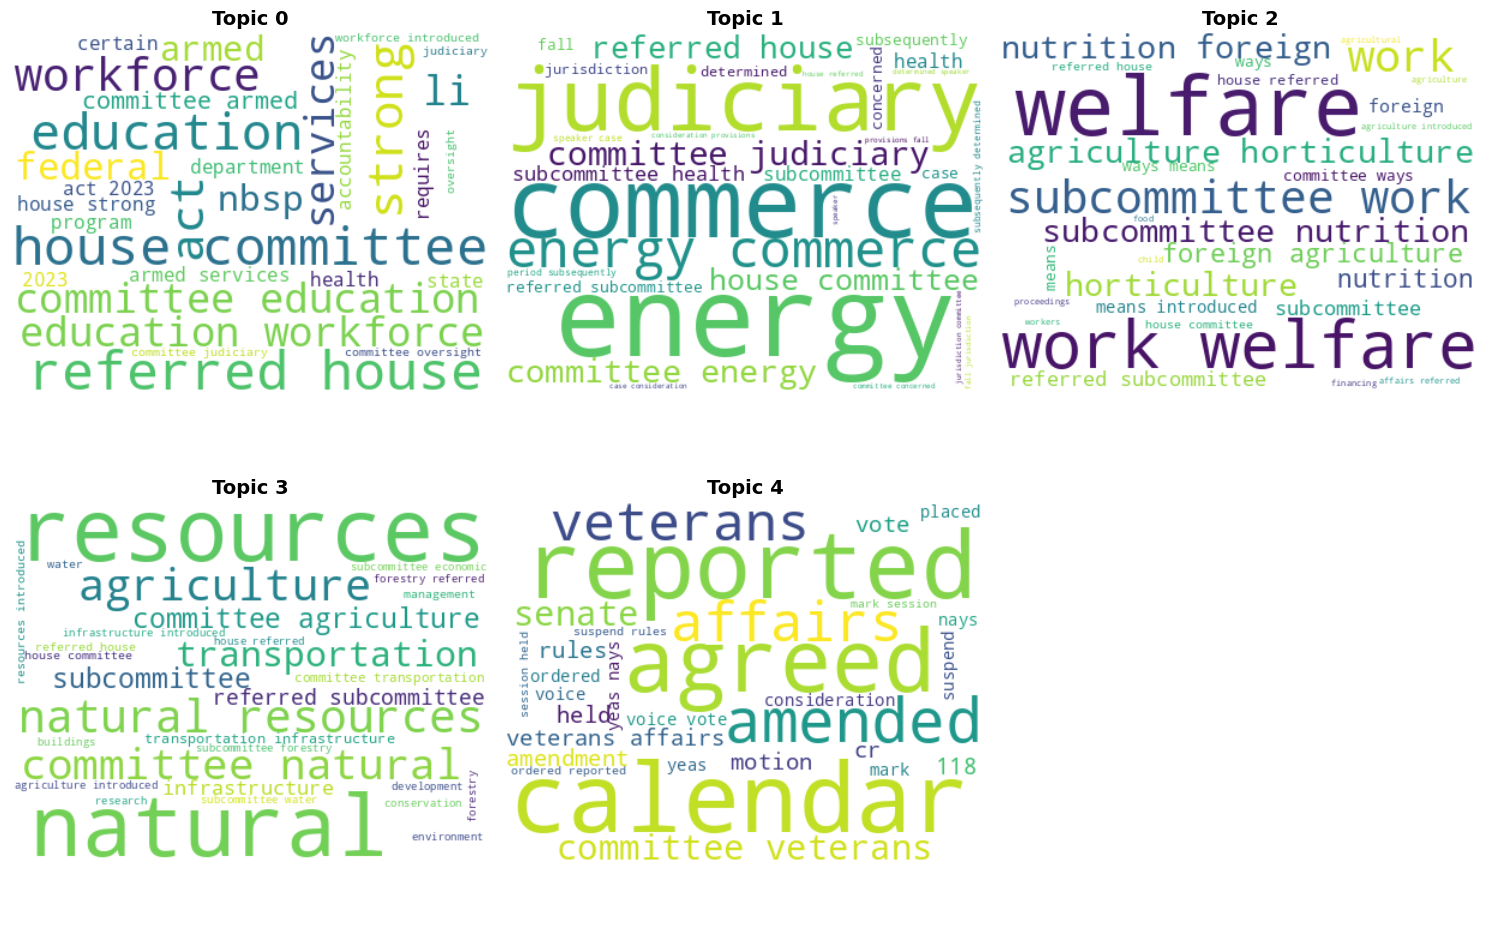

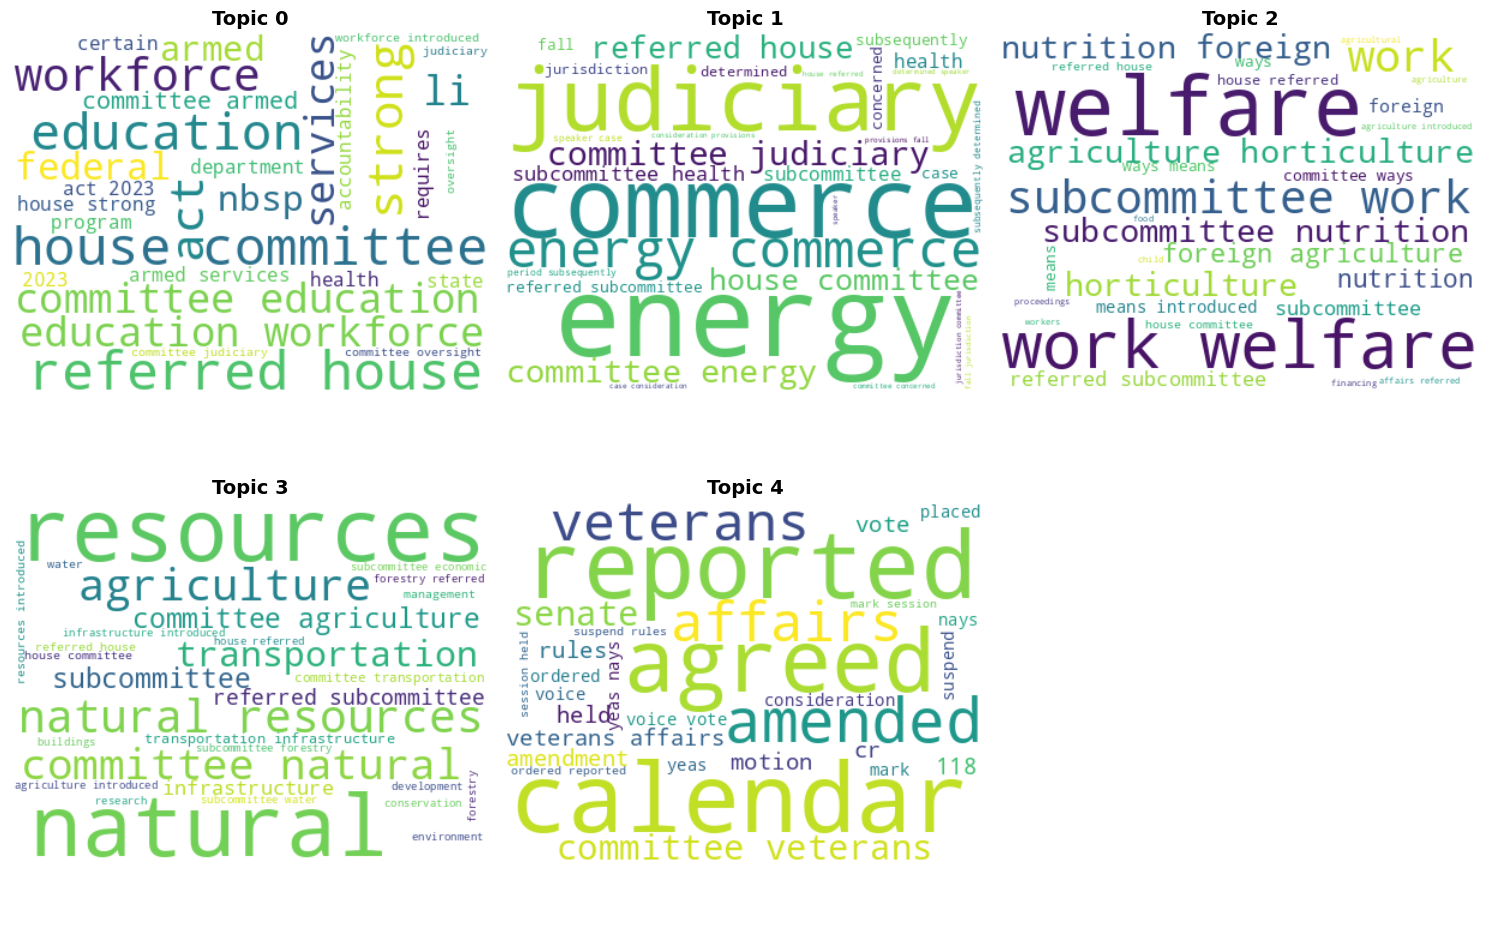

In [ ]:
import requests
data = requests.get("https://raw.githubusercontent.com/daalft/polviz/main/data/bills_text.json")
bills_data = data.json()

# n_topics indicates the number of requested topics
tm = BillsTopicModeling(bills_data, n_topics=5)
# max_features indicates the maximum number of features (words)
tm.preprocess_and_vectorize(method='tfidf', max_features=1000)
tm.fit_lda()
tm.visualize_topics_wordcloud()

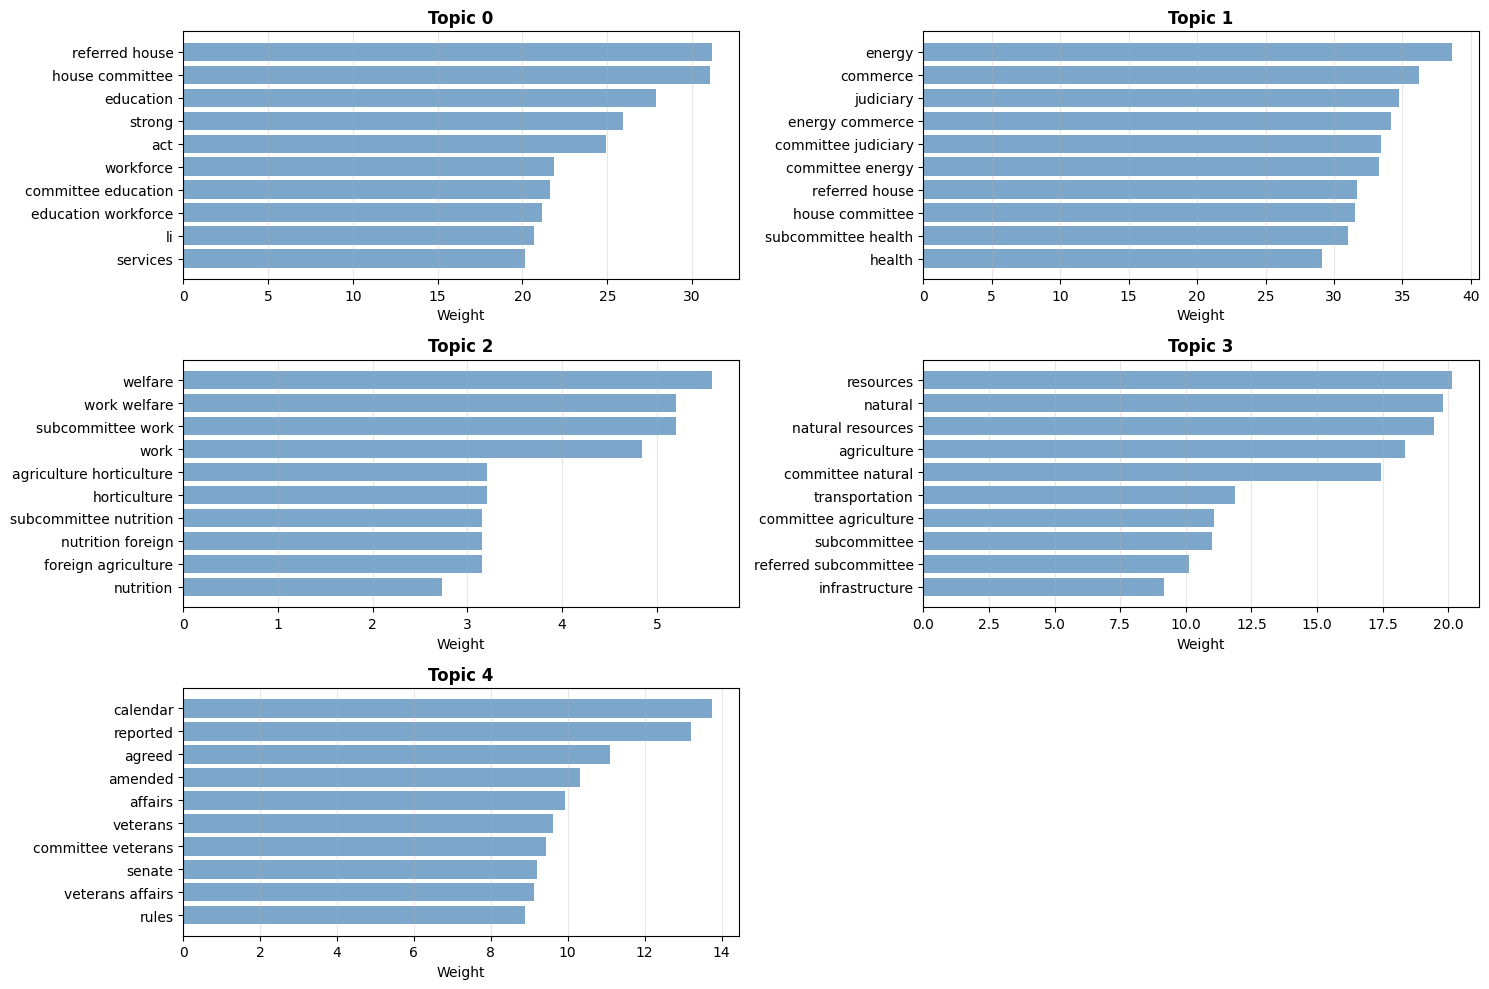

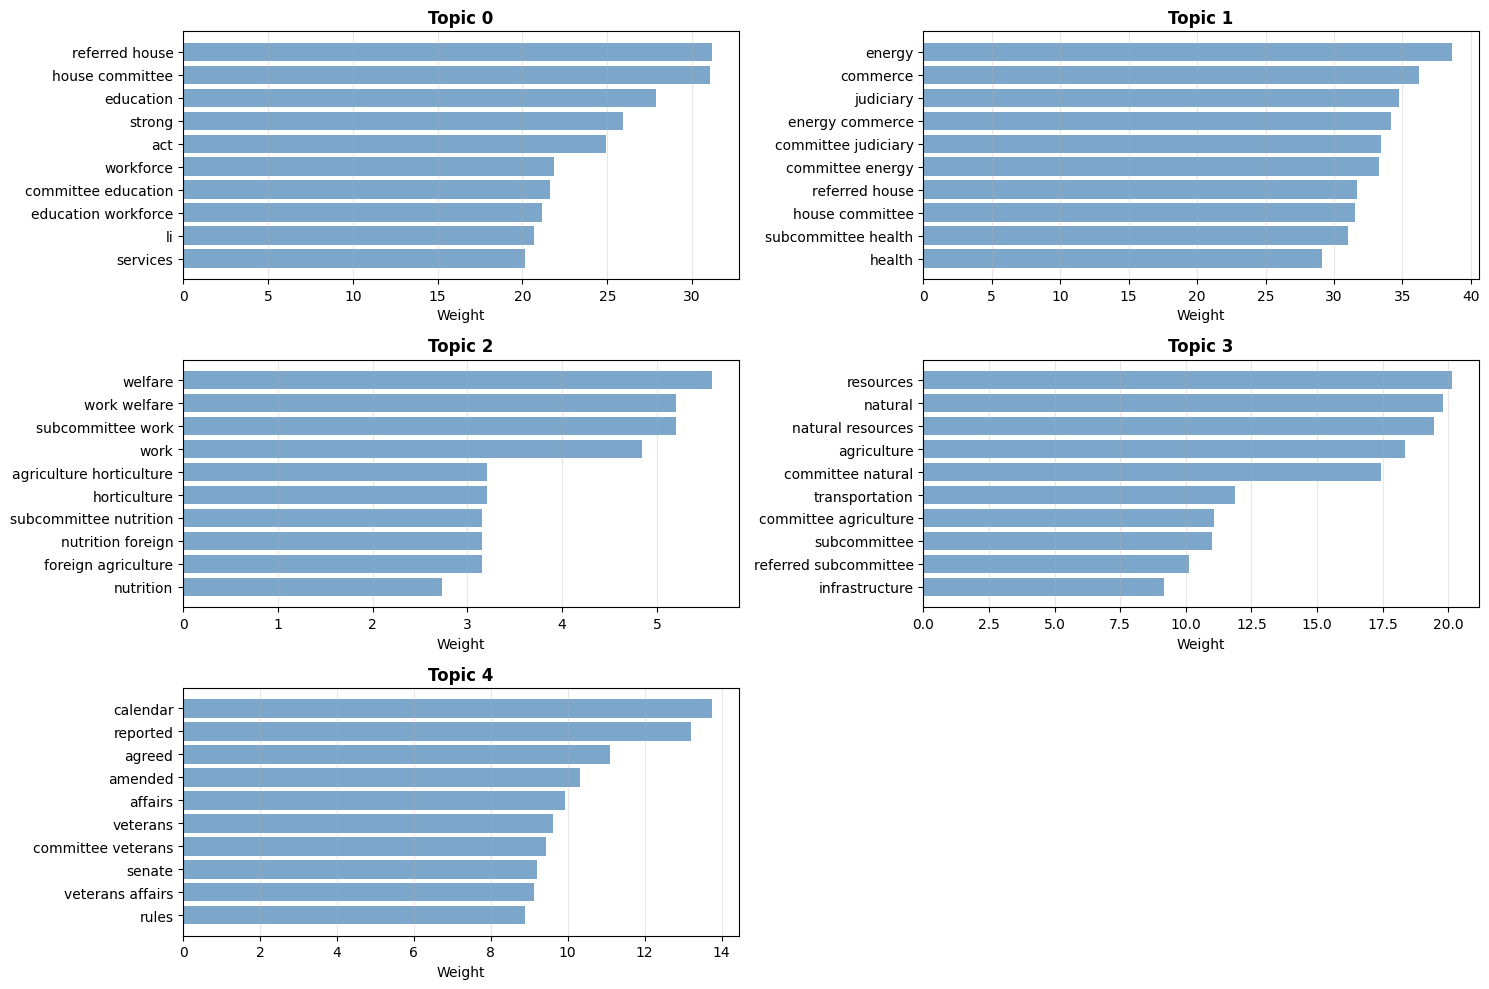

In [ ]:
tm.visualize_topic_bar_charts()

## Temporal trends
Now we look at temporal trends. The below data contains ANES open answers from the years 2016, 2020 and 2024 to the question: "most important problems facing the country". Look at the data. How would you process it? How would you visualize it?

In [ ]:
import pandas as pd

base_url = "https://raw.githubusercontent.com/daalft/polviz/main/data/prob_20{}.pickle"

problems_2016 = pd.read_pickle(base_url.format(16))
problems_2020 = pd.read_pickle(base_url.format(20))
problems_2024 = pd.read_pickle(base_url.format(24))

Let's look at the first five responses from 2016

In [ ]:
problems_2016[:5]

['terrorists\n',
 'IMIAGRATION\n',
 '-9\n',
 'My opinion is that the working class is being taxed too heavily and we are being subsidsized the non working class//rich keep getting richer and the poor keep getting poorer//\n',
 'Unemployment there is too much oif it\n']

Now let's look at the first five responses from 2020

In [ ]:
problems_2020[:5]

['racim both for blacks and whites false information\n',
 'coming together as a country\n',
 'severe political polarization that does not allow for compromise or growth\n',
 'pandemic (covid-19)\n',
 'globalism, Fake covid, law and order, BLM, public education, socialism, businesses being destroyed by globalist governors\n']

In [ ]:
problems_2024[:5]

["immigration we can't take care of our own people yet alone a million others \n",
 'The cost of everything, people can not afford groceries or housing basic needs to live. When more than half or your check is going to food you can not plan and save for emergencies.\n',
 'threats to democracy \n',
 'economy and leadership. \n',
 'Economy, Border, \n']

Now that we have looked at the data, let's visualize the most prominent words per year.

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


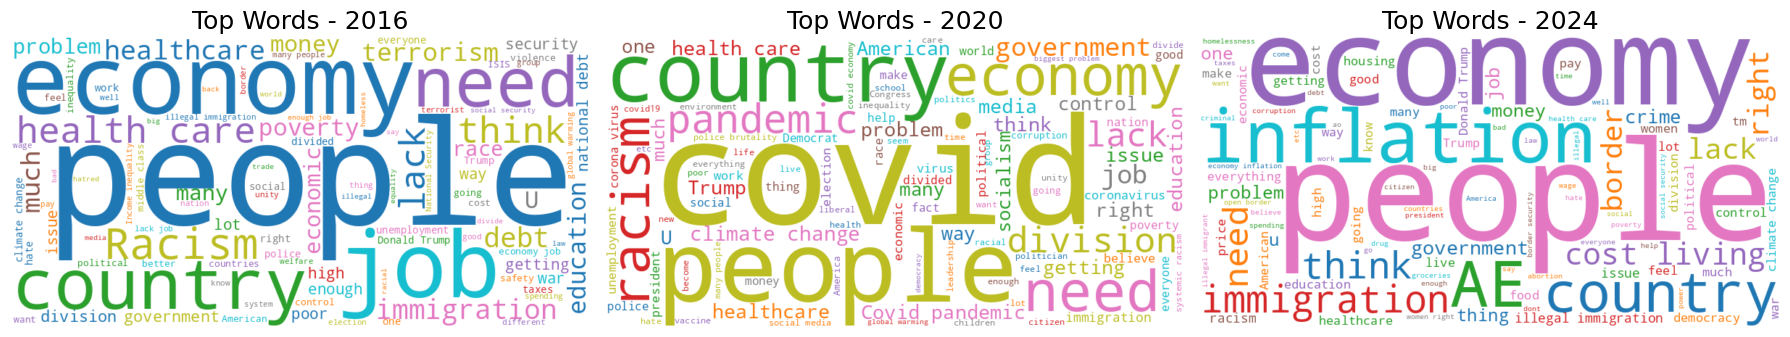

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
problem_map = {'2016': problems_2016, '2020': problems_2020, '2024': problems_2024}
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, year in enumerate(['2016', '2020', '2024']):
    text = " ".join(problem_map[year])
    # filter stopwords
    text = " ".join([word for word in text.split() if word not in stopwords])

    wc = WordCloud(width=800, height=400, background_color='white',
                   max_words=100, colormap='tab10').generate(text)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Top Words - {year}", fontsize=18)
    axes[i].axis("off")

plt.tight_layout()
plt.show()